**Dogs vs. Cats**

data source: https://www.kaggle.com/competitions/dogs-vs-cats-redux-kernels-edition/overview

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, KFold
from sklearn.metrics import accuracy_score, mean_squared_error, roc_curve, auc, confusion_matrix,classification_report

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense,Input, Convolution2D, MaxPooling2D,Conv2D, Dropout, Flatten,Activation, BatchNormalization,GlobalMaxPooling2D, GlobalAveragePooling2D, LeakyReLU
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.preprocessing import image
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers.legacy import Adam, SGD
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy

# for model
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import VGG19, Xception, EfficientNetV2L

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score, RandomizedSearchCV
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

**Download kaggle data**

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"clairetsao","key":"62466306072ea310bf8aca3336762f52"}'}

In [ ]:
!pip install -q kaggle
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

rm: cannot remove '/root/.kaggle': No such file or directory


In [ ]:
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition

100% 812M/814M [00:23<00:00, 34.2MB/s]
100% 814M/814M [00:23<00:00, 36.9MB/s]


In [ ]:
!mkdir data
!unzip dogs-vs-cats-redux-kernels-edition.zip -d data

Archive:  dogs-vs-cats-redux-kernels-edition.zip
  inflating: data/sample_submission.csv  
  inflating: data/test.zip           
  inflating: data/train.zip          


In [ ]:
!unzip data/test.zip -d data/
!unzip data/train.zip -d data/

串流輸出內容已截斷至最後 5000 行。
  inflating: data/train/dog.5499.jpg  
  inflating: data/train/dog.55.jpg   
  inflating: data/train/dog.550.jpg  
  inflating: data/train/dog.5500.jpg  
  inflating: data/train/dog.5501.jpg  
  inflating: data/train/dog.5502.jpg  
  inflating: data/train/dog.5503.jpg  
  inflating: data/train/dog.5504.jpg  
  inflating: data/train/dog.5505.jpg  
  inflating: data/train/dog.5506.jpg  
  inflating: data/train/dog.5507.jpg  
  inflating: data/train/dog.5508.jpg  
  inflating: data/train/dog.5509.jpg  
  inflating: data/train/dog.551.jpg  
  inflating: data/train/dog.5510.jpg  
  inflating: data/train/dog.5511.jpg  
  inflating: data/train/dog.5512.jpg  
  inflating: data/train/dog.5513.jpg  
  inflating: data/train/dog.5514.jpg  
  inflating: data/train/dog.5515.jpg  
  inflating: data/train/dog.5516.jpg  
  inflating: data/train/dog.5517.jpg  
  inflating: data/train/dog.5518.jpg  
  inflating: data/train/dog.5519.jpg  
  inflating: data/train/dog.552.jpg  
  inflat

**Data Exploration**

In [ ]:
TRAIN_DIR = '/content/data/train'
TEST_DIR = '/content/data/test'

In [ ]:
train_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)]
test_images = [TEST_DIR+i for i in os.listdir(TEST_DIR)]

train_dogs = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'dog' in i]
train_cats = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'cat' in i]

In [ ]:
labels = []
for i in os.listdir(TRAIN_DIR):
    if 'dog' in i:
        labels.append(1)
    else:
        labels.append(0)

In [ ]:
file_names = os.listdir(TRAIN_DIR)

In [ ]:
df = pd.DataFrame(data = {'path': [os.path.join(TRAIN_DIR, file_name) for file_name in file_names], 'label': labels})

In [ ]:
df

,path,label
0,/content/data/train/cat.5497.jpg,0
1,/content/data/train/cat.7567.jpg,0
2,/content/data/train/dog.4590.jpg,1
3,/content/data/train/cat.4823.jpg,0
4,/content/data/train/dog.10859.jpg,1
...,...,...
24995,/content/data/train/cat.5029.jpg,0
24996,/content/data/train/cat.3883.jpg,0
24997,/content/data/train/cat.10262.jpg,0
24998,/content/data/train/dog.2552.jpg,1


**Split training and validation data**

In [ ]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
total_train = train_df.shape[0]
total_val = val_df.shape[0]

**Preparing image data**

In [ ]:
def preprocess(image, label):
    raw_image = tf.io.read_file(image)
    decoded_image = tf.image.decode_jpeg(raw_image, channels=3)
    resized_image = tf.image.resize(decoded_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

batch_size = 32

train_dataset = tf.data.Dataset.from_tensor_slices((train_df['path'].values, train_df['label'].values))
val_dataset = tf.data.Dataset.from_tensor_slices((val_df['path'].values, val_df['label'].values))

train_dataset = train_dataset.shuffle(1000).repeat()
train_dataset = train_dataset.map(lambda x, y: preprocess(x, y)).batch(batch_size).prefetch(1)

val_dataset = val_dataset.map(lambda x, y: preprocess(x, y)).batch(batch_size).prefetch(1)

**Training**

 I experimented with three different pre-trained models for binary classification, including VGG16, ResNet50, and Xception

**Model - VGG16**

The kaggle score for VGG16 model is 0.1667

In [ ]:
# Load VGG16 Base Model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# Build the Custom Model
inputs = keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(1, activation='sigmoid')(x)
model_VGG16 = Model(inputs, outputs)
model_VGG16.summary()

opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)
model_VGG16.compile(optimizer=opt, loss='BinaryCrossentropy', metrics=[BinaryAccuracy()])

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_7  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_13 (Dense)            (None, 512)               262656    
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_14 (Dense)            (None, 1)                 513       
                                                           

In [ ]:
#fit the model
result2 = model_VGG16.fit(
    train_dataset,
    epochs=15,
    validation_data=val_dataset,
    steps_per_epoch=int(total_train / batch_size),
    class_weight={0: 1.0, 1: 1.0}
)

Epoch 1/15
625/625 [==============================] - 33s 50ms/step - loss: 0.1630 - binary_accuracy: 0.9348 - val_loss: 0.1122 - val_binary_accuracy: 0.9550
Epoch 2/15
625/625 [==============================] - 31s 49ms/step - loss: 0.1095 - binary_accuracy: 0.9549 - val_loss: 0.1067 - val_binary_accuracy: 0.9572
Epoch 3/15
625/625 [==============================] - 31s 49ms/step - loss: 0.1045 - binary_accuracy: 0.9575 - val_loss: 0.1006 - val_binary_accuracy: 0.9584
Epoch 4/15
625/625 [==============================] - 31s 50ms/step - loss: 0.0972 - binary_accuracy: 0.9609 - val_loss: 0.0994 - val_binary_accuracy: 0.9582
Epoch 5/15
625/625 [==============================] - 31s 50ms/step - loss: 0.0951 - binary_accuracy: 0.9617 - val_loss: 0.0985 - val_binary_accuracy: 0.9620
Epoch 6/15
625/625 [==============================] - 31s 49ms/step - loss: 0.0926 - binary_accuracy: 0.9618 - val_loss: 0.1394 - val_binary_accuracy: 0.9440
Epoch 7/15
625/625 [==============================] 

In [ ]:
file_names_t = os.listdir(TEST_DIR)
test = pd.DataFrame(data = {'path': [os.path.join(TEST_DIR, file_name) for file_name in file_names_t]})

In [ ]:
# preparing image for test image
def preprocess(image):
    raw_image = tf.io.read_file(image)
    decoded_image = tf.image.decode_jpeg(raw_image, channels=3)
    resized_image = tf.image.resize(decoded_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image

batch_size = 32

test_data = tf.data.Dataset.from_tensor_slices(test['path'].values)
test_data = test_data.map(lambda x: preprocess(x)).batch(batch_size)

In [ ]:
predictions = model_VGG16.predict(test_data)

391/391 [==============================] - 15s 38ms/step


In [ ]:
import re
test_predictions = pd.DataFrame()
test_predictions['id'] = test['path'].apply(lambda x: re.findall(r'\d+', x))
test_predictions['label'] = (predictions)
test_predictions['id'] = test_predictions['id'].apply(lambda x: int(x[0]) if x else None)
test_predictions.to_csv('vgg16.csv', index=False)
test_predictions.head()

,id,label
0,1601,1.562330e-07
1,4916,1.490964e-01
2,11352,9.994898e-01
3,10567,1.000000e+00
4,11771,3.120611e-04


**Model - ResNet50**

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

inputs = keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(1, activation='sigmoid')(x)
model_ResNet50 = Model(inputs, outputs)
model_ResNet50.summary()

opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.01)
model_ResNet50.compile(optimizer=opt, loss='BinaryCrossentropy', metrics=[BinaryAccuracy()])

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_9  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_17 (Dense)            (None, 512)               1049088   
                                                                 
 dropout_8 (Dropout)         (None, 512)               0         
                                                                 
 dense_18 (Dense)            (None, 1)                 513       
                                                           

In [ ]:
result_ResNet50 = model_ResNet50.fit(
    train_dataset,
    epochs=15,
    validation_data=val_dataset,
    steps_per_epoch=int(total_train / batch_size),
    class_weight={0: 1.0, 1: 1.0}
)

Epoch 1/15
625/625 [==============================] - 31s 44ms/step - loss: 0.6896 - binary_accuracy: 0.6069 - val_loss: 0.6404 - val_binary_accuracy: 0.6266
Epoch 2/15
625/625 [==============================] - 27s 43ms/step - loss: 0.6366 - binary_accuracy: 0.6332 - val_loss: 0.6186 - val_binary_accuracy: 0.6802
Epoch 3/15
625/625 [==============================] - 27s 43ms/step - loss: 0.6329 - binary_accuracy: 0.6402 - val_loss: 0.5917 - val_binary_accuracy: 0.7008
Epoch 4/15
625/625 [==============================] - 27s 43ms/step - loss: 0.6200 - binary_accuracy: 0.6474 - val_loss: 0.5894 - val_binary_accuracy: 0.7112
Epoch 5/15
625/625 [==============================] - 27s 43ms/step - loss: 0.6085 - binary_accuracy: 0.6618 - val_loss: 0.5626 - val_binary_accuracy: 0.7074
Epoch 6/15
625/625 [==============================] - 27s 43ms/step - loss: 0.6037 - binary_accuracy: 0.6521 - val_loss: 0.5637 - val_binary_accuracy: 0.7150
Epoch 7/15
625/625 [==============================] 

**Model - Xception**

The kaggle score for pre-trained Xception model is 0.07509

In [ ]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

inputs = keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
# after adding the layer of LeakyReLU, the RMSE reduce from 0.1552 to 0.07509
x = LeakyReLU()(x)
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(1, activation='sigmoid')(x)
model_X = Model(inputs, outputs)
model_X.summary()

opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)
model_X.compile(optimizer=opt, loss='BinaryCrossentropy', metrics=[BinaryAccuracy()])

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_38 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 7, 7, 2048)        0         
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
 7 (GlobalAveragePooling2D)                                      
                                                                 
 dense_31 (Dense)            (None, 512)               1049088   
                                                                 
 dropout_15 (Dropout)        (None, 512)               0         
                                                          

In [ ]:
result_X = model_X.fit(
    train_dataset,
    epochs=5,
    validation_data=val_dataset,
    steps_per_epoch=int(total_train / batch_size),
)

Epoch 1/5
625/625 [==============================] - 36s 54ms/step - loss: 0.0523 - binary_accuracy: 0.9830 - val_loss: 0.0288 - val_binary_accuracy: 0.9894
Epoch 2/5
625/625 [==============================] - 33s 53ms/step - loss: 0.0311 - binary_accuracy: 0.9895 - val_loss: 0.0313 - val_binary_accuracy: 0.9898
Epoch 3/5
625/625 [==============================] - 33s 53ms/step - loss: 0.0275 - binary_accuracy: 0.9904 - val_loss: 0.0277 - val_binary_accuracy: 0.9902
Epoch 4/5
625/625 [==============================] - 33s 53ms/step - loss: 0.0217 - binary_accuracy: 0.9927 - val_loss: 0.0434 - val_binary_accuracy: 0.9844
Epoch 5/5
625/625 [==============================] - 33s 53ms/step - loss: 0.0184 - binary_accuracy: 0.9932 - val_loss: 0.0327 - val_binary_accuracy: 0.9900


In [ ]:
predictions_X = model_X.predict(test_data)

391/391 [==============================] - 16s 39ms/step


In [ ]:
import re
test_predictions = pd.DataFrame()
test_predictions['id'] = test['path'].apply(lambda x: re.findall(r'\d+', x))
test_predictions['label'] = (predictions_X)
test_predictions['id'] = test_predictions['id'].apply(lambda x: int(x[0]) if x else None)
test_predictions.to_csv('MSBA_Session1_ClaireTsao.csv', index=False)
test_predictions.head()

,id,label
0,1601,0.000199
1,4916,0.001554
2,11352,0.999996
3,10567,0.999958
4,11771,0.000013


**Final Result**

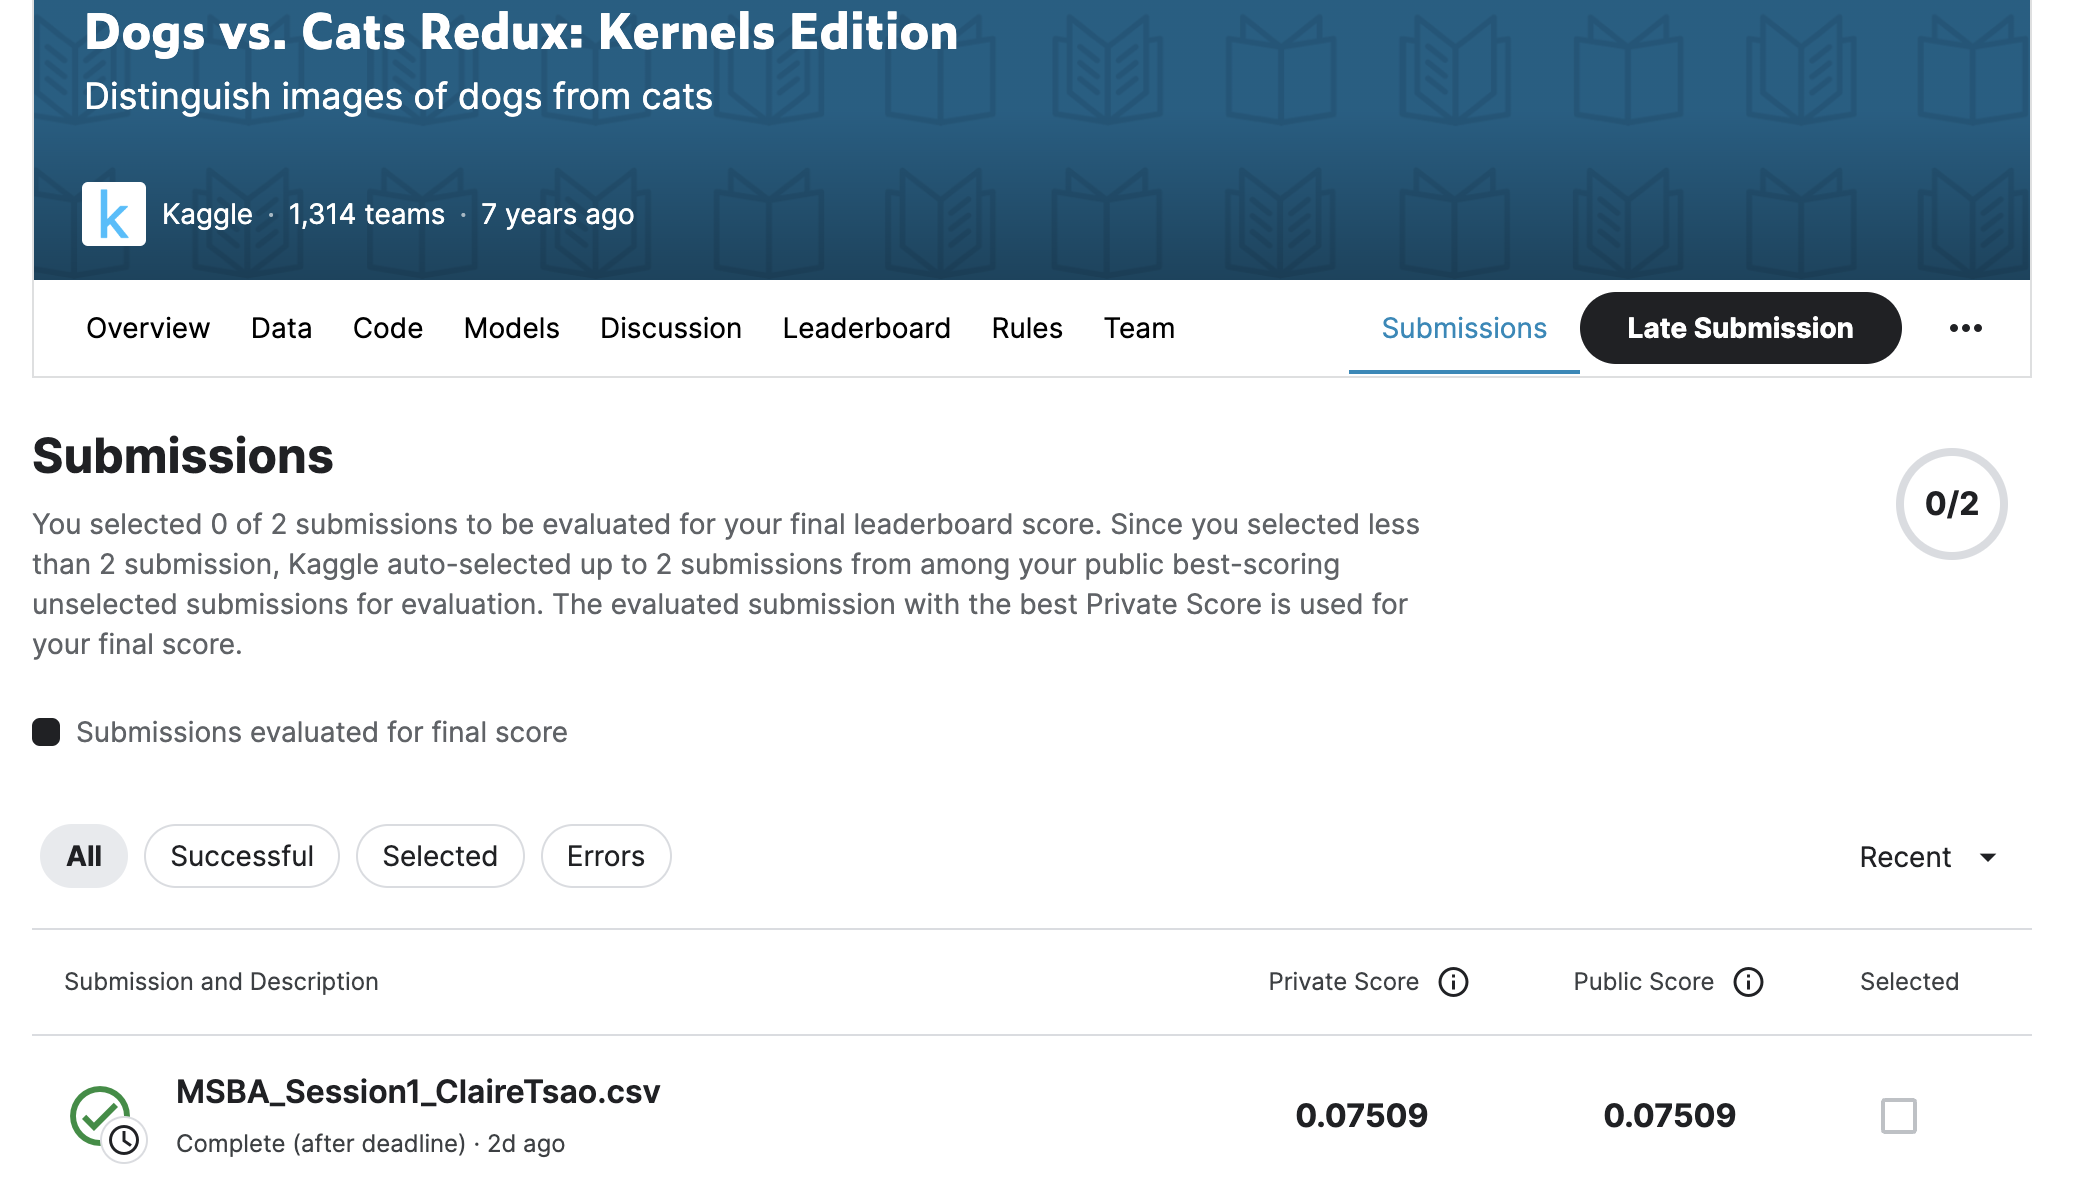